[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'AAPL Price'}, xlabel='Date'>

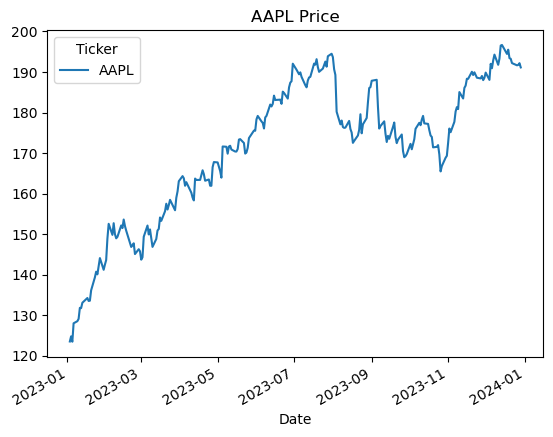

In [4]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Download historical price data
ticker = "AAPL"
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")
data = data['Close']
data.plot(title=f"{ticker} Price")

[*********************100%***********************]  1 of 1 completed


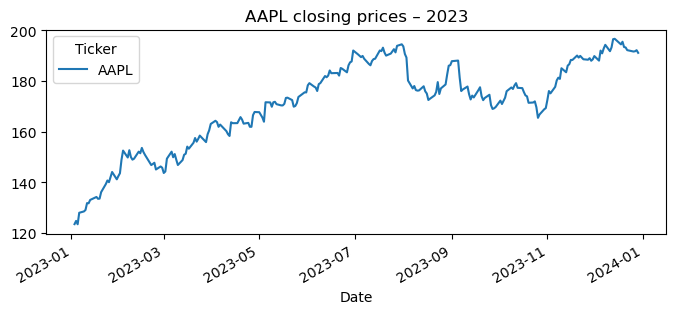

Initializing NUTS using jitter+adapt_diag...


250 daily log-returns from 2023-01-03 to 2023-12-29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


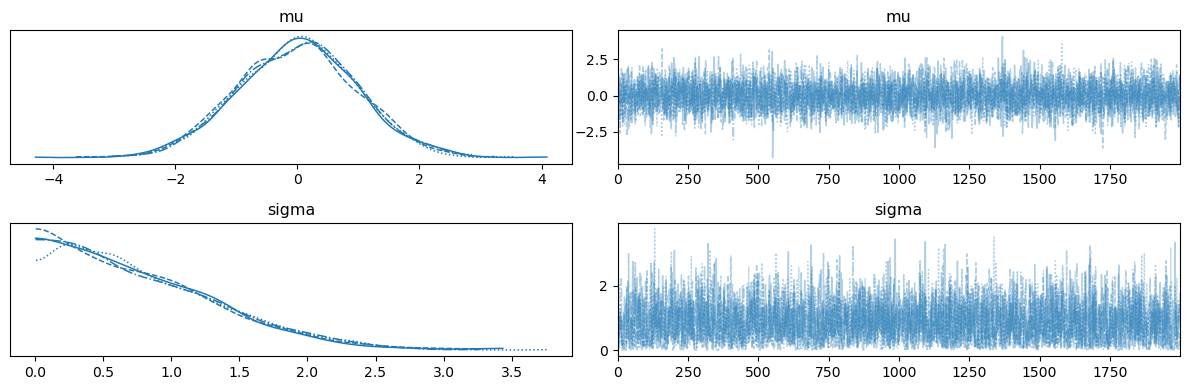

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0011,0.9739,-1.8293,1.8244,0.0147,0.0121,4403.7612,4041.2094,1.0006
sigma,0.8033,0.6027,0.0009,1.8819,0.0101,0.0068,2385.4921,1957.8042,1.0020


In [14]:
# --- 1. Imports -------------------------------------------------------------
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# --- 2. Download daily closes for 2023 -------------------------------------
ticker = "AAPL"
prices = (
    yf.download(ticker, start="2023-01-01", end="2023-12-31")  # daily bars
      ["Close"]                                                # keep only Close column
      .dropna()
)
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()

# --- 3. Transform to log-returns (the GBM observation) ---------------------
log_returns = np.diff(np.log(prices.values))              # r_t = ln(S_{t}/S_{t-1})
dt = 1/252                                                # one trading day expressed in years

print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
      f"to {prices.index[-1].date()}")

# --- 4. Bayesian inference with PyMC ---------------------------------------
with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=1.0)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=1.0)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = log_returns
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2_000,
        tune          = 2_000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


In [6]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(market_price, S, K, T, r, option_type='call'):
    def difference(sigma):
        bs_price = black_scholes_price(S, K, T, r, sigma, option_type)
        return bs_price - market_price

    result = brentq(difference, 1e-6, 5)
    return result

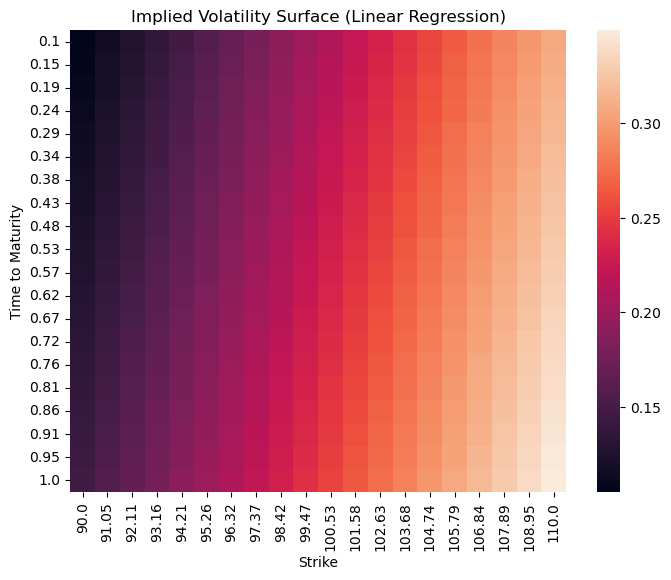

In [9]:
# Dummy data (replace with real market data)
np.random.seed(0)
K = np.linspace(90, 110, 20)
T = np.linspace(0.1, 1.0, 20)
K_grid, T_grid = np.meshgrid(K, T)
IV = 0.2 + 0.01 * (K_grid - 100) + 0.05 * T_grid + np.random.normal(0, 0.01, size=K_grid.shape)

X = np.column_stack([K_grid.ravel(), T_grid.ravel()])
y = IV.ravel()

reg = LinearRegression().fit(X, y)
IV_pred = reg.predict(X).reshape(K_grid.shape)

# Plot surface
plt.figure(figsize=(8,6))
sns.heatmap(IV_pred, xticklabels=np.round(K, 2), yticklabels=np.round(T, 2))
plt.title("Implied Volatility Surface (Linear Regression)")
plt.xlabel("Strike")
plt.ylabel("Time to Maturity")
plt.show()


In [11]:
import pymc as pm
import arviz as az

# Simulated option data
S = 100
K = 100
T = 0.5
r_true = 0.01
sigma_true = 0.2
observed_price = black_scholes_price(S, K, T, r_true, sigma_true)

with pm.Model() as model:
    sigma = pm.Uniform("sigma", 0.01, 1.0)
    r = pm.Uniform("r", 0.0, 0.1)
    
    theoretical_price = black_scholes_price(S, K, T, r, sigma)
    
    obs = pm.Normal("obs", mu=theoretical_price, sigma=1.0, observed=observed_price)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

az.plot_trace(trace, var_names=["sigma", "r"])
plt.show()


TypeError: TensorVariable cannot be converted to Python boolean. Call `.astype(bool)` for the symbolic equivalent.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


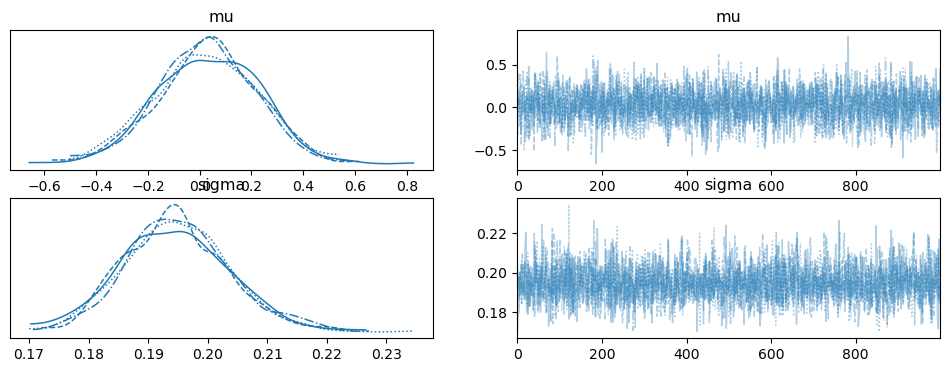

In [12]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Simulate GBM data (you can later replace this with real stock prices)
np.random.seed(42)
T = 1.0  # total time in years
N = 252  # number of time steps (e.g., trading days)
dt = T / N
mu_true = 0.05
sigma_true = 0.2

S0 = 100
returns = np.random.normal(mu_true * dt, sigma_true * np.sqrt(dt), size=N)
S = S0 * np.exp(np.cumsum(returns))

log_returns = np.diff(np.log(S))

# Bayesian Inference
with pm.Model() as gbm_model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    likelihood = pm.Normal("returns", mu=mu * dt, sigma=sigma * np.sqrt(dt), observed=log_returns)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

az.plot_trace(trace, var_names=["mu", "sigma"])
plt.show()


[*********************100%***********************]  1 of 1 completed


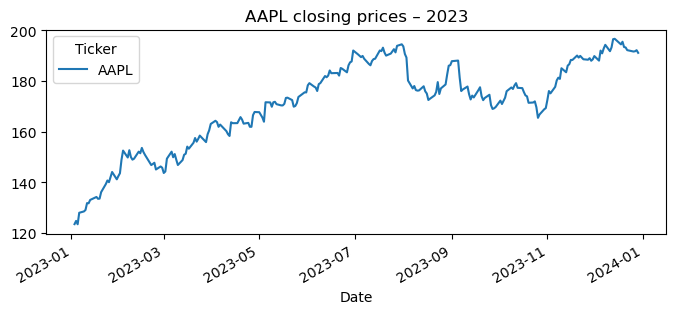

Initializing NUTS using jitter+adapt_diag...


250 daily log-returns from 2023-01-03 to 2023-12-29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


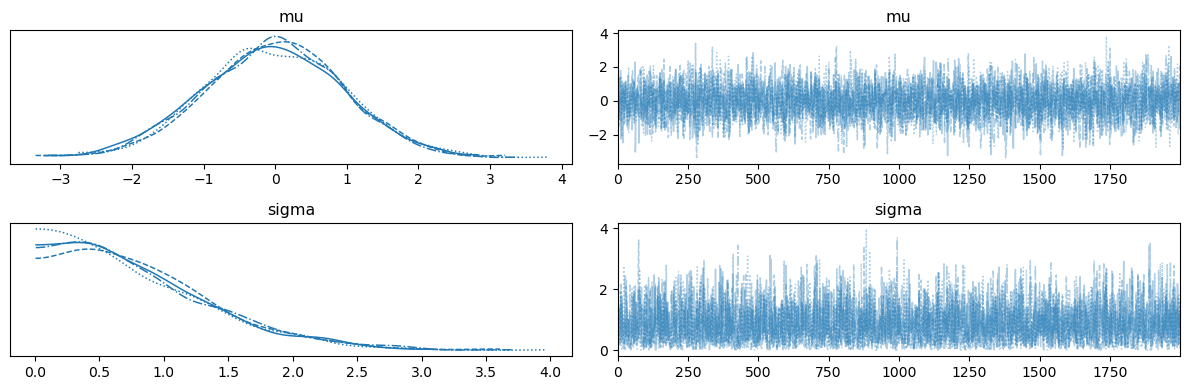

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.0197,0.9786,-1.8322,1.8461,0.0163,0.0126,3596.2035,3921.0559,1.0004
sigma,0.8047,0.5982,0.0001,1.9017,0.0096,0.0074,2794.7859,2320.6417,1.0025


In [13]:
# --- 1. Imports -------------------------------------------------------------
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# --- 2. Download daily closes for 2023 -------------------------------------
ticker = "AAPL"
prices = (
    yf.download(ticker, start="2023-01-01", end="2023-12-31")  # daily bars
      ["Close"]                                                # keep only Close column
      .dropna()
)
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()

# --- 3. Transform to log-returns (the GBM observation) ---------------------
log_returns = np.diff(np.log(prices.values))              # r_t = ln(S_{t}/S_{t-1})
dt = 1/252                                                # one trading day expressed in years

print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
      f"to {prices.index[-1].date()}")

# --- 4. Bayesian inference with PyMC ---------------------------------------
with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=1.0)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=1.0)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = log_returns
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2_000,
        tune          = 2_000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)
